# Tutorial: obtaining the Koopman generator via Newton's extrapolation

This tutorial shows you how to compute the infinitesimal generator with the Newton's polynomial extrapolation and use it to cluster the coherent sets of the molecule Alanine-Dipeptide.

First, we load the modules we need. In addition to numpy and matplolib, we use the picking algorithm, the Galerkin discretization, Newton extrapolation of the generator and finally PCCA+ / GenPCCA.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#standard libraries
import numpy as np
import matplotlib.pyplot as plt
#from cmdtools
from cmdtools.estimation import picking_algorithm, galerkin, newton_generator
from cmdtools.analysis import pcca

We load a precomputed trajectory from the `arr_0.py` file but use thinned out version for snappier performance.

In [57]:
#load trajectory 
diala = np.load("arr_0.npy")
diala = diala[::5, :]
diala.shape

(50000, 2)

For the choice of the Gaussian basis functions for the upcoming Galerkin discretization we precluster the data using the picking algorithm. Simplified one could say it is a version of K-means which has the property that the chosen points (called `centers`) are spread out more uniformly, thus also giving a good coverage of the transition regions with few observed samples.

In [58]:
#pick the centers for the basis functions
centers = picking_algorithm.picking_algorithm(diala[::5,:], 350)[0]
# we reccomend to sort your centers so it is easier to interpret their assignment to clusters.
centers = centers[centers[:, 0].argsort()]

Let us now plot positions of the picked centers in the state space.

You can see that this algorithm ensures that the sampling is localized in the region of of the state space covered by the trajectory. 

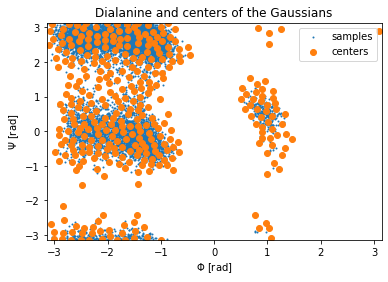

In [60]:
plt.scatter( diala[::5, 0], diala[::5, 1], label= "samples", s=1)
plt.scatter(centers[:, 0], centers[:, 1], label= "centers")
plt.xlabel("$\Phi$ [rad]")
plt.ylabel("$\Psi$ [rad]")
plt.title("Dialanine and centers of the Gaussians")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.legend()
plt.show()

Now that we have the trajectory as well as the (basis-) centers we can perform the Galerkin projection of the trajectory onto the basis and estimate the corresponding Koopman matrix.


The variance of the Gaussian ansatz functions is set to $\sigma=0.09$. 

In [61]:
G = galerkin.Gaussian(diala[::1,:], centers, sigma=0.09)
K = G.propagator

Note that since we are using a meshless discretization the Ansatz functions overlap.
This reflects in the fact the the Koopman matrix for zero lag time, $S := K(\tau=0)$ is not diagonal.
In order to account for the "phantom transitions" induced merely by
this overlap and not the underlying dynamics, we will pass this (optional) matrix to the pcca routine later on.


In [62]:
S = G.mass

Based on the membership assignment of the trajectory samples to the Ansatz basis we can compute the Koopman matrix for different lag-times $\tau = 1, 2, ..$

Then we can apply the Newton's polynomial extrapolation method to this set of Koopman matrices to estimate the infinitesimal generator of the system.

The following routines handles this for $\tau = 1,2,3$:

In [64]:
Q = newton_generator.newton_generator(G, 3)

Last step: The Koopman matrix $K(\tau)$ and the generator $Q$ are used succesively as input for PCCA+.

Given a desired number of clusters, PCCA+ computes the dominant spectrum of the supplied operator via the Schur decomposition to computed a coarse graining projection onto a space of clusters / metastable states.

We observed obseved 4 clusters from an analysis of the Schurvalues, but you can try to vary the number of clusters and see how the results change.

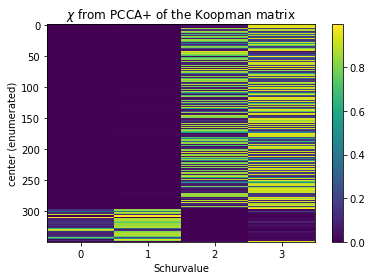

In [63]:
p = pcca.PCCA(K, 4, massmatrix=S)
chi = p.chi

plt.imshow(chi, aspect="auto", interpolation="nearest")
plt.title("$\chi$ from PCCA+ of the Koopman matrix")
plt.xticks(np.arange(0,np.shape(chi)[1]))
plt.xlabel("Schurvalue")
plt.ylabel("center (enumerated)")
plt.colorbar()
plt.show()

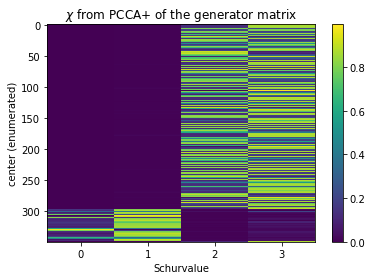

In [65]:
p = pcca.PCCA(Q, 4, massmatrix=S)
chi_q = p.chi

plt.imshow(chi_q, aspect= "auto", interpolation="nearest")
plt.title("$\chi$ from PCCA+ of the generator matrix")
plt.xticks(np.arange(0,np.shape(chi)[1]))
plt.xlabel("Schurvalue")
plt.ylabel("center (enumerated)")
plt.colorbar()
plt.show()

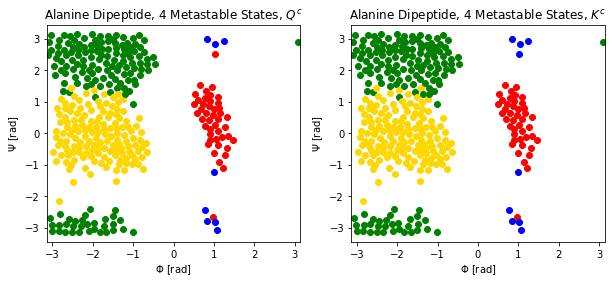

In [66]:
#visualize with center belongs to which metastable state, in addition compare the results for the 
#PCCA+ applied to the transfer matrix and to the generator.
colors = ["b","r","gold","g", "m", "purple"]
#centers_1 = centers[centers_kept, :]
plt.figure(figsize=(10, 4))

plt.subplot(121)
for i in range(np.shape(chi_q)[0]):
    plt.scatter(centers[i, 0], centers[i, 1], color = colors[np.argmax(chi_q[i, :])])
    
plt.xlabel("$\Phi$ [rad]")
plt.ylabel("$\Psi$ [rad]")
plt.title("Alanine Dipeptide, 4 Metastable States, $Q^c$")
plt.xlim(-np.pi, np.pi)


plt.subplot(122)
for i in range(np.shape(chi)[0]):
    plt.scatter(centers[i, 0], centers[i, 1], color = colors[np.argmax(chi[i, :])])

plt.xlabel("$\Phi$ [rad]")
plt.ylabel("$\Psi$ [rad]")
plt.title("Alanine Dipeptide, 4 Metastable States, $K^c$")
plt.xlim(-np.pi, np.pi)
plt.show()

The coarse grained generator can be obtained with $Q^c=\chi^{-1}Q\chi$

In [11]:
# todo: check if this is correct (really pseudoinverse?, what about the inverse of the massmatrix?)
Q_c = np.linalg.pinv(chi_q).dot(Q.dot(chi_q))